The second part of task 3 consists of the development of a deep learning model to predict the taxi trip demand in spatio-temporal resolution.

In [12]:
##### Imports #####

import pandas as pd
import numpy as np
import h3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
##### Load Data #####

test_df = pd.read_csv("testing_no_null.csv")

In [4]:
##### Data Overview ######
print("Dataset columns: \n", test_df.columns)
test_df.head()

Dataset columns: 
 Index(['Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area',
       'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid  Location'],
      dtype='object')


,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051,17.12,1.703198e+10,1.703132e+10,76,32,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004,1.18,1.703184e+10,1.703184e+10,32,32,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
2,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484,1.59,1.703128e+10,1.703132e+10,28,32,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
3,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686,13.01,1.703132e+10,1.703198e+10,32,56,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
4,4628ef9dfa973bdfe877c5aa9d9738f9dc1204e54f2f1a...,2024-01-09 15:15:00,2024-01-09 15:30:00,1047,3.02,1.703133e+10,1.703108e+10,33,8,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)


In [5]:
##### Hexagon Distribution #####
def latlon_to_h3(lat, lon, res=8):
    return h3.geo_to_h3(lat, lon, res)

test_df['Pickup_H3'] = test_df.apply(lambda row: latlon_to_h3(row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude']), axis=1)
test_df['Dropoff_H3'] = test_df.apply(lambda row: latlon_to_h3(row['Dropoff Centroid Latitude'], row['Dropoff Centroid Longitude']), axis=1)


In [ ]:
##### Data Preprocessing #####

# convert time data
test_df['Trip Start Timestamp'] = pd.to_datetime(test_df['Trip Start Timestamp'])
test_df['Time_Bucket'] = test_df['Trip Start Timestamp'].dt.floor('1H')
test_df['Hour'] = test_df['Trip Start Timestamp'].dt.hour
test_df['DayOfWeek'] = test_df['Trip Start Timestamp'].dt.dayofweek
test_df['IsWeekend'] = test_df['DayOfWeek'].isin([5, 6]).astype(int)
test_df['Pickup Census Tract'] = test_df['Pickup Census Tract'].astype(str)

# compute hourly trip count
agg = test_df.groupby(['Pickup Census Tract', 'Time_Bucket']).size().reset_index(name='Trip_Count')
features = test_df.groupby(['Pickup Census Tract', 'Time_Bucket']).agg({
    'Hour': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first'
}).reset_index()
ml_df = pd.merge(agg, features, on=['Pickup Census Tract', 'Time_Bucket'])
agg.head()


/var/folders/mx/mgs457fj45n14v_glyg8_qwc0000gn/T/ipykernel_97177/296806865.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_df['Time_Bucket'] = test_df['Trip Start Timestamp'].dt.floor('1H')


,Pickup Census Tract,Time_Bucket,Trip_Count
0,17031010100.0,2024-02-27 07:00:00,2
1,17031010100.0,2024-03-14 17:00:00,1
2,17031010100.0,2024-05-16 07:00:00,1
3,17031010100.0,2024-08-14 15:00:00,2
4,17031010100.0,2024-09-17 07:00:00,2


In [14]:
ml_df.head()

,Pickup Census Tract,Time_Bucket,Trip_Count,Hour,DayOfWeek,IsWeekend
0,17031010100.0,2024-02-27 07:00:00,2,7,1,0
1,17031010100.0,2024-03-14 17:00:00,1,17,3,0
2,17031010100.0,2024-05-16 07:00:00,1,7,3,0
3,17031010100.0,2024-08-14 15:00:00,2,15,2,0
4,17031010100.0,2024-09-17 07:00:00,2,7,1,0


In [15]:
##### Feature Engineering & Train-Test Split #####
X = ml_df[['Pickup Census Tract', 'Hour', 'DayOfWeek', 'IsWeekend']]
y = ml_df['Trip_Count']

# Preprocess categorical and numerical features
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Pickup Census Tract']),
    ('num', StandardScaler(), ['Hour', 'DayOfWeek', 'IsWeekend'])
])


We decided to start with the most simple architecture of a neural network: one hidden layer

In [17]:
##### Prediction & Evaluation #####
X_processed = preprocessor.fit_transform(X)

# Convert sparse matrix to dense for Keras
X_processed = X_processed.toarray()

##### Step 3: Train-Test Split #####
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

##### Step 4: Build and Train Model #####
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1)  # Output: predicted trip count
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stop])

##### Step 5: Evaluation #####
y_pred = model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")



Epoch 1/50
4362/4362 [==============================] - 10s 2ms/step - loss: 370.5182 - mae: 10.3734 - val_loss: 268.7589 - val_mae: 9.1592
Epoch 2/50
4362/4362 [==============================] - 8s 2ms/step - loss: 260.4854 - mae: 9.0584 - val_loss: 245.9404 - val_mae: 8.7900
Epoch 3/50
4362/4362 [==============================] - 8s 2ms/step - loss: 243.0162 - mae: 8.6087 - val_loss: 233.4117 - val_mae: 8.2626
Epoch 4/50
4362/4362 [==============================] - 8s 2ms/step - loss: 231.3470 - mae: 8.2980 - val_loss: 223.0585 - val_mae: 8.1201
Epoch 5/50
4362/4362 [==============================] - 8s 2ms/step - loss: 224.2765 - mae: 8.1329 - val_loss: 218.7306 - val_mae: 8.0343
Epoch 6/50
4362/4362 [==============================] - 7s 2ms/step - loss: 219.6339 - mae: 8.0297 - val_loss: 214.6896 - val_mae: 7.8879
Epoch 7/50
4362/4362 [==============================] - 8s 2ms/step - loss: 215.9954 - mae: 7.9463 - val_loss: 211.4200 - val_mae: 7.9192
Epoch 8/50
4362/4362 [==========

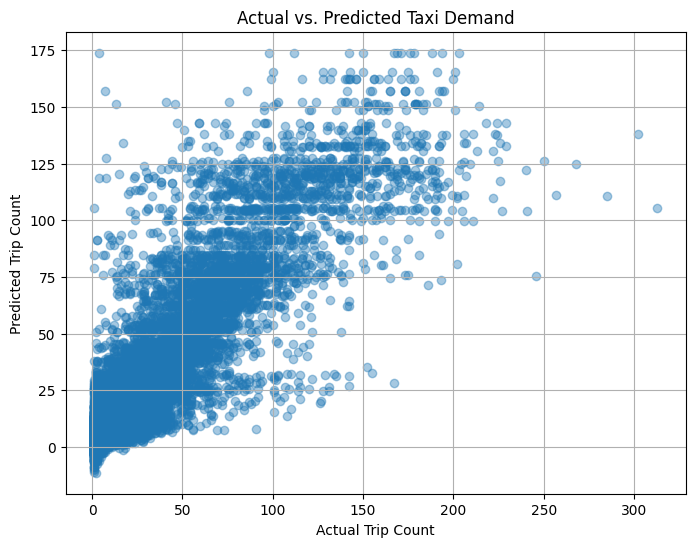

In [13]:
##### Evaluation Visualization #####

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Actual vs. Predicted Taxi Demand")
plt.grid(True)
plt.show()